# PyTorch Introduction

Today, we will be intoducing PyTorch, "an open source deep learning platform that provides a seamless path from research prototyping to production deployment".

This notebook is by no means comprehensive. If you have any questions the documentation and Google are your friends.

Goal takeaways:
- Automatic differentiation is a powerful tool
- PyTorch implements common functions used in deep learning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

torch.manual_seed(446)
np.random.seed(446)

## Tensors and relation to numpy

By this point, we have worked with numpy quite a bit. PyTorch's basic building block, the `tensor` is similar to numpy's `ndarray`

In [2]:
# we create tensors in a similar way to numpy nd arrays
x_numpy = np.array([0.1, 0.2, 0.3])
x_torch = torch.tensor([0.1, 0.2, 0.3])
print('x_numpy, x_torch')
print(x_numpy, x_torch)
print()

# to and from numpy, pytorch
print('to and from numpy and pytorch')
print(torch.from_numpy(x_numpy), x_torch.numpy())
print()

# we can do basic operations like +-*/
y_numpy = np.array([3,4,5.])
y_torch = torch.tensor([3,4,5.])
print("x+y")
print(x_numpy + y_numpy, x_torch + y_torch)
print()

# many functions that are in numpy are also in pytorch
print("norm")
print(np.linalg.norm(x_numpy), torch.norm(x_torch))
print()

# to apply an operation along a dimension,
# we use the dim keyword argument instead of axis
print("mean along the 0th dimension")
x_numpy = np.array([[1,2],[3,4.]])
x_torch = torch.tensor([[1,2],[3,4.]])
print(np.mean(x_numpy, axis=0), torch.mean(x_torch, dim=0))


x_numpy, x_torch
[0.1 0.2 0.3] tensor([0.1000, 0.2000, 0.3000])

to and from numpy and pytorch
tensor([0.1000, 0.2000, 0.3000], dtype=torch.float64) [0.1 0.2 0.3]

x+y
[3.1 4.2 5.3] tensor([3.1000, 4.2000, 5.3000])

norm
0.37416573867739417 tensor(0.3742)

mean along the 0th dimension
[2. 3.] tensor([2., 3.])


### `Tensor.view`
We can use the `Tensor.view()` function to reshape tensors similarly to `numpy.reshape()`

It can also automatically calculate the correct dimension if a `-1` is passed in. This is useful if we are working with batches, but the batch size is unknown.

In [3]:
# "MNIST"
N, C, W, H = 10000, 3, 28, 28
X = torch.randn((N, C, W, H))

print(X.shape)
print(X.view(N, C, 784).shape)
print(X.view(-1, C, 784).shape) # automatically choose the 0th dimension

torch.Size([10000, 3, 28, 28])
torch.Size([10000, 3, 784])
torch.Size([10000, 3, 784])


## Computation graphs

What's special about PyTorch's `tensor` object is that it implicitly creates a computation graph in the background. A computation graph is a a way of writing a mathematical expression as a graph. There is an algorithm to compute the gradients of all the variables of a computation graph in time on the same order it is to compute the function itself.

Consider the expression $e=(a+b)*(b+1)$ with values $a=2, b=1$. We can draw the evaluated computation graph as
<br>
<br>

![tree-img](https://colah.github.io/posts/2015-08-Backprop/img/tree-def.png)

[source](https://colah.github.io/posts/2015-08-Backprop/)

In PyTorch, we can write this as

In [4]:
a = torch.tensor(2.0, requires_grad=True) # we set requires_grad=True to let PyTorch know to keep the graph
b = torch.tensor(1.0, requires_grad=True)
c = a + b
d = b + 1
e = c * d
print('c', c)
print('d', d)
print('e', e)

c tensor(3., grad_fn=<AddBackward0>)
d tensor(2., grad_fn=<AddBackward0>)
e tensor(6., grad_fn=<MulBackward0>)


We can see that PyTorch kept track of the computation graph for us.

## PyTorch as an auto grad framework

Now that we have seen that PyTorch keeps the graph around for us, let's use it to compute some gradients for us.

Consider the function $f(x) = (x-2)^2$.

Q: Compute $\frac{d}{dx} f(x)$ and then compute $f'(1)$.

We make a `backward()` call on the leaf variable (`y`) in the computation, computing all the gradients of `y` at once.

In [5]:
def f(x):
    return (x-2)**2

def fp(x):
    return 2*(x-2)

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

print('Analytical f\'(x):', fp(x))
print('PyTorch\'s f\'(x):', x.grad)


Analytical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
PyTorch's f'(x): tensor([-2.])


It can also find gradients of functions.

Let $w = [w_1, w_2]^T$

Consider $g(w) = 2w_1w_2 + w_2\cos(w_1)$

**Question:** Compute $\nabla_w g(w)$ and verify $\nabla_w g([\pi,1]) = [2, \pi - 1]^T$

**Answer** Recall, $\nabla_w g(w) = (\frac{\partial g(w)}{\partial w_1},\frac{\partial g(w)}{\partial w_1}) = (2w_2-w_2sin(w_1), 2w_1+\cos(w_1))$

In [6]:
def g(w):
    return 2*w[0]*w[1] + w[1]*torch.cos(w[0])

def grad_g(w):
    return torch.tensor([2*w[1] - w[1]*torch.sin(w[0]), 2*w[0] + torch.cos(w[0])])

w = torch.tensor([np.pi, 1], requires_grad=True)

z = g(w)
z.backward()

print('Analytical grad g(w)', grad_g(w))
print('PyTorch\'s grad g(w)', w.grad)


Analytical grad g(w) tensor([2.0000, 5.2832])
PyTorch's grad g(w) tensor([2.0000, 5.2832])


## Using the gradients
Now that we have gradients, we can use our favorite optimization algorithm: gradient descent!

Let $f$ the same function we defined above.

**Question:** What is the value of $x$ that minimizes $f$?

**Answer:** Set the gradient equal to 0 and solve for $w_1, w_2$

In [7]:
x = torch.tensor([5.0], requires_grad=True)
step_size = 0.25

print('iter,\tx,\tf(x),\tf\'(x),\tf\'(x) pytorch')
for i in range(15):
    y = f(x)
    y.backward() # compute the gradient
    
    print('{},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f}'.format(i, x.item(), f(x).item(), fp(x).item(), x.grad.item()))
    
    x.data = x.data - step_size * x.grad # perform a GD update step
    
    # We need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    # The detach_() is for efficiency. You do not need to worry too much about it.
    x.grad.detach_()
    x.grad.zero_()

iter,	x,	f(x),	f'(x),	f'(x) pytorch
0,	5.000,	9.000,	6.000,	6.000
1,	3.500,	2.250,	3.000,	3.000
2,	2.750,	0.562,	1.500,	1.500
3,	2.375,	0.141,	0.750,	0.750
4,	2.188,	0.035,	0.375,	0.375
5,	2.094,	0.009,	0.188,	0.188
6,	2.047,	0.002,	0.094,	0.094
7,	2.023,	0.001,	0.047,	0.047
8,	2.012,	0.000,	0.023,	0.023
9,	2.006,	0.000,	0.012,	0.012
10,	2.003,	0.000,	0.006,	0.006
11,	2.001,	0.000,	0.003,	0.003
12,	2.001,	0.000,	0.001,	0.001
13,	2.000,	0.000,	0.001,	0.001
14,	2.000,	0.000,	0.000,	0.000


# Linear Regression with Gradient Descent

<!-- Now, instead of minimizing a made-up function, lets minimize a loss function on some made-up data. -->

<!-- We will implement Gradient Descent in order to solve the task of linear regression. -->

### Generating our data for Linear Regression
We create a bunch of random inputs x and y. 

x is generated from a random normal distribution. 

y is calculated using $y_i = w x_i + b +\epsilon_i = 10x_i-1+\epsilon$


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import torch
import torch.optim as optim

n = 100
# Draw a bunch of random x's
x = torch.normal(0.,1.,size=(n,1)) 
# Compute noise y's
y = 10*x - 1+torch.normal(0.,2,size=(n,1)) 

# variables to store the w and b we need to learn
what = torch.tensor(20., requires_grad=True)
bhat = torch.tensor(20., requires_grad=True)

### Gradient Descent

We create a `trajectory` list which contains what, bhat and loss at each iteration. We assume the `learning rate` to be 0.1. Loss at each iteration is calculated using $\frac{1}{100}\sum_{i=1}^{100} (y_i - (w\cdot x_i+b))^2$

In [9]:
trajectory = []
lr = .1
for i in range(20):
    # compute the current function value
    loss = torch.mean((y - (what*x + bhat))**2) #+ .1*what**2
    # add the current point to the trajectory
    trajectory.append([what.item(), bhat.item(), loss.item()])
    # differentiate
    loss.backward()
    # update the point using gradient descent
    with torch.no_grad():
        what -= lr*what.grad
        what.grad.zero_()

        bhat -= lr*bhat.grad
        bhat.grad.zero_()

trajectory = np.array(trajectory)

### Visualizing Gradient Descent

We make three graphs - 
1. The first plot is the contours of the loss function: $\frac{1}{100}\sum_{i=1}^{100} (y_i - (w\cdot x_i+b))^2$. We see how the values of ``what`` and ``bhat`` converge to a global minimum of the loss. 
2. Second, we plot the `loss` function where the number of iterations are plotted against the loss.
3. Third, we plot the `regression line` at every fifth iteration.

Note that the final ``what`` and ``bhat`` that are learned are close to the original parameters (look at where the minimum of the loss contour plot is).



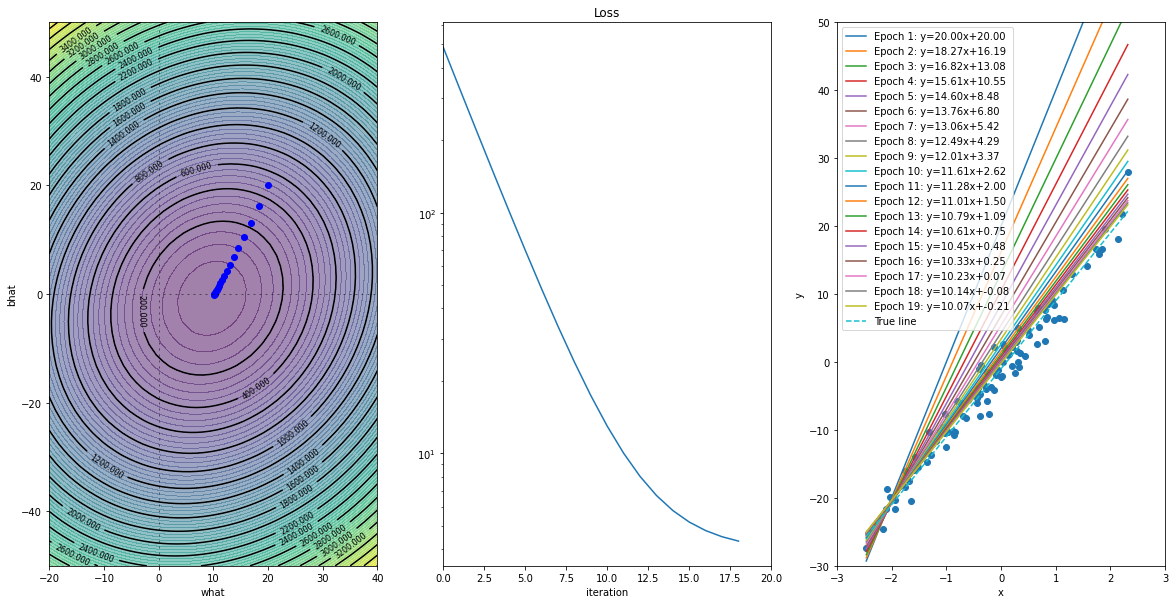

In [10]:
import time
import IPython
# Plotting code
#y = y.numpy()
#x = x.numpy()
ws,bs = np.meshgrid(np.linspace(-20,40,50),np.linspace(-50,50,50))
l = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        # print(((y-(ws[i,j]*x+bs[i,j]))**2).shape, ((y-(ws[i,j]*x+bs[i,j]))**2).dtype, type(((y-(ws[i,j]*x+bs[i,j]))**2)))
        l[i,j] = torch.mean((y-(ws[i,j]*x+bs[i,j]))**2) 
    
print(l)
# IPython.display.clear_output(wait=True)

for i in range(0,20):
    IPython.display.clear_output(wait=True)
    fig = plt.gcf()    
    fig.set_size_inches(20,10)
    ax1 = fig.add_subplot(1,3,1)
    ax1.contourf(ws, bs, l, levels=100, alpha=.5)
    cs = ax1.contour(ws, bs, l, levels=20, colors='black')
    ax1.clabel(cs, inline=1, fontsize=8)
    ax1.axhline(0, color='black', alpha=.5, dashes=[2, 4], linewidth=1)
    ax1.axvline(0, color='black', alpha=0.5, dashes=[2, 4], linewidth=1)
    ax1.set_ylabel('bhat')
    ax1.set_xlabel('what')
    ax1.scatter(trajectory[:,0][:i], trajectory[:,1][:i], c='blue', marker='o')
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_yscale('log')
    ax2.plot(trajectory[:,2][:i])
    ax2.set_xlabel('iteration')
    ax2.set_xlim([0,len(trajectory[:,0])])
    ax2.set_title('Loss')

    ax3 = fig.add_subplot(1,3,3)
    for n, (w_, b_, _) in enumerate(trajectory[:i]):
        x_ = np.linspace(torch.min(x), torch.max(x), 100)
        y_ = w_ * x_ + b_
        ax3.plot(x_, y_, label="Epoch {}: y={:.2f}x+{:.2f}".format(n+1, w_, b_))
        
    x_ = np.linspace(torch.min(x), torch.max(x), 100)
    ax3.plot(x_, 10*x_-1, '--', label="True line")
    ax3.scatter(x,y)    
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_xlim([-3,3])
    ax3.set_ylim([-30,50])
    plt.legend()
    plt.show()
    time.sleep(.5)

    #print('current best what, bhat', w_, b_)

<!-- ### Sanity check
To verify PyTorch is computing the gradients correctly, let's recall the gradient for the RSS objective:

$$\nabla_w \mathcal{L}_{RSS}(w; X) = \nabla_w\frac{1}{n} ||y - Xw||_2^2 = -\frac{2}{n}X^T(y-Xw)$$

Let's see if the match up: -->

<!-- Now that we've seen PyTorch is doing the right think, let's use the gradients!

## Linear regression using GD with automatically computed derivatives

We will now use the gradients to run the gradient descent algorithm.

Note: This example is an illustration to connect ideas we have seen before to PyTorch's way of doing things. We will see how to do this in the "PyTorchic" way in the next example. -->

# Doing Linear Regression the PyTorch way

## Background: torch.nn.Module

`Module` is PyTorch's way of performing operations on tensors. Modules are implemented as subclasses of the `torch.nn.Module` class. All modules are callable and can be composed together to create complex functions.

[`torch.nn` docs](https://pytorch.org/docs/stable/nn.html)

Note: most of the functionality implemented for modules can be accessed in a functional form via `torch.nn.functional`, but these require you to create and manage the weight tensors yourself.

[`torch.nn.functional` docs](https://pytorch.org/docs/stable/nn.html#torch-nn-functional).

### Linear Module
The bread and butter of modules is the Linear module which does a linear transformation with a bias. It takes the input and output dimensions as parameters, and creates the weights in the object.

Unlike how we initialized our $w$ manually, the Linear module automatically initializes the weights randomly. For minimizing non convex loss functions (e.g. training neural networks), initialization is important and can affect results. If training isn't working as well as expected, one thing to try is manually initializing the weights to something different from the default. PyTorch implements some common initializations in `torch.nn.init`.

[`torch.nn.init` docs](https://pytorch.org/docs/stable/nn.html#torch-nn-init)

In [11]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)

example_tensor = torch.tensor([[1.,2,3], [4,5,6]])
# applys a linear transformation to the data
transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transormed', transformed.shape)
print()
print('We can see that the weights exist in the background\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([2, 3])
transormed torch.Size([2, 4])

We can see that the weights exist in the background

W: Parameter containing:
tensor([[ 0.1860, -0.1630,  0.5095],
        [ 0.4718,  0.3283, -0.4821],
        [-0.3024,  0.2483, -0.2510],
        [ 0.5047, -0.3910,  0.0861]], requires_grad=True)
b: Parameter containing:
tensor([ 0.4954,  0.1743, -0.5169, -0.5706], requires_grad=True)


### Activation functions
PyTorch implements a number of activation functions including but not limited to `ReLU`, `Tanh`, and `Sigmoid`. Since they are modules, they need to be instantiated.

In [12]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([0., 1., 0.])


Note: we can access *all* of the parameters (of any `nn.Module`) with the `parameters()` method. 

### Loss functions
PyTorch implements many common loss functions including `MSELoss` and `CrossEntropyLoss`.

TODO: Add some math explaining these losses

In [13]:
mse_loss_fn = nn.MSELoss()

input = torch.tensor([[0., 0, 0]])
target = torch.tensor([[1., 0, -1]])

loss = mse_loss_fn(input, target)

print(loss)

tensor(0.6667)


## Background: torch.optim
PyTorch implements a number of gradient-based optimization methods in `torch.optim`, including Gradient Descent. At the minimum, it takes in the model parameters and a learning rate.

Optimizers do not compute the gradients for you, so you must call `backward()` yourself. You also must call the `optim.zero_grad()` function before calling `backward()` since by default PyTorch does and inplace add to the `.grad` member variable rather than overwriting it.

This does both the `detach_()` and `zero_()` calls on all tensor's `grad` variables.

[`torch.optim` docs](https://pytorch.org/docs/stable/optim.html)

In [14]:
# create a simple model
model = nn.Linear(1, 1)

# create a simple dataset
X_simple = torch.tensor([[1.]])
y_simple = torch.tensor([[2.]])

# create our optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

y_hat = model(X_simple)
print('model params before:', model.weight)
loss = mse_loss_fn(y_hat, y_simple)
optim.zero_grad()
loss.backward()
optim.step()
print('model params after:', model.weight)


model params before: Parameter containing:
tensor([[0.6096]], requires_grad=True)
model params after: Parameter containing:
tensor([[0.6255]], requires_grad=True)


As we can see, the parameter was updated in the correct direction

## Linear regression using GD with automatically computed derivatives and PyTorch's Modules

Now let's combine what we've learned to solve the linear regression from above in a "PyTorchic" way.

Again, we seem to be able to recover our linear model, $y=10x-1$

In [15]:
step_size = 0.1
n = 100
# Draw a bunch of random x's
x = torch.normal(0.,1.,size=(n,1)) 
# Compute noise y's
y = 10*x - 1+torch.normal(0.,2,size=(n,1)) 

linear_module = nn.Linear(x.size(1), 1, bias=True)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)

print('iter,\tloss,\tw')

for i in range(20):
    y_hat = linear_module(x)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    # print(linear_module.weight)
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.detach().numpy()))

# print('\ntrue w\t\t', true_w.view(2).numpy())
print()
print('estimated w\t', linear_module.weight.detach().numpy())
print('estimated b\t', linear_module.bias.detach().numpy())

iter,	loss,	w
0,	121.55,	[[1.2026598]]
1,	80.83,	[[2.8906305]]
2,	54.18,	[[4.258002]]
3,	36.73,	[[5.3657055]]
4,	25.31,	[[6.2630844]]
5,	17.83,	[[6.9900994]]
6,	12.93,	[[7.5791135]]
7,	9.73,	[[8.056338]]
8,	7.62,	[[8.443003]]
9,	6.25,	[[8.756303]]
10,	5.34,	[[9.010166]]
11,	4.75,	[[9.215877]]
12,	4.36,	[[9.382572]]
13,	4.11,	[[9.517656]]
14,	3.94,	[[9.627128]]
15,	3.83,	[[9.715845]]
16,	3.76,	[[9.787745]]
17,	3.71,	[[9.846018]]
18,	3.68,	[[9.893248]]
19,	3.66,	[[9.931528]]

estimated w	 [[9.931528]]
estimated b	 [-1.1620487]


# Neural Network Basics in PyTorch

<!-- Let's consider the dataset from hw3. We will try and fit a simple neural network to the data. -->

In [16]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as datasets

We will be using the `MNIST` dataset, an inbuilt dataset in PyTorch to classify handwritten digits. The following lines download the dataset.

In [17]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


We visualize a bunch of images from the dataset we loaded.




dimension of input: torch.Size([1, 28, 28])
total length of training set: 60000
total length of test set: 10000


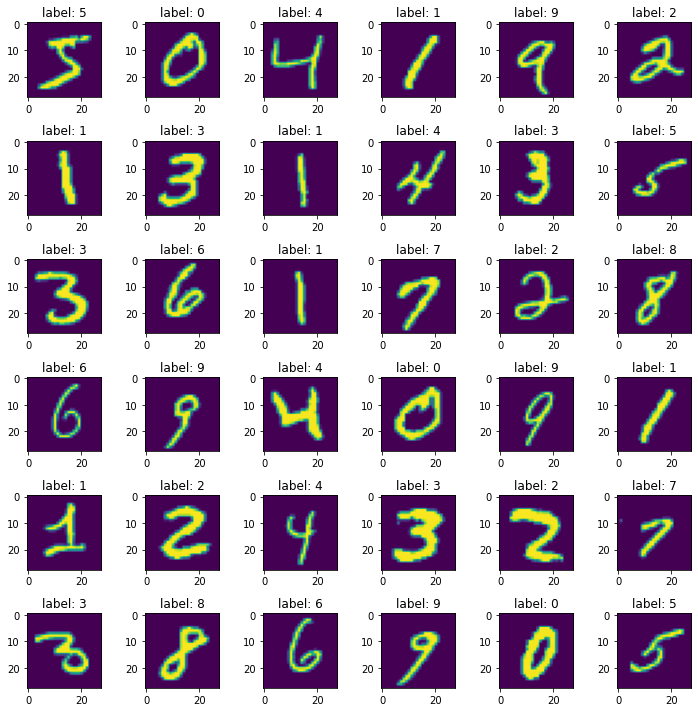

In [18]:
import matplotlib.pyplot as plt
fix, ax = plt.subplots(6,6, figsize=(10,10))
print('dimension of input:', train_dataset[0][0].shape)
print('total length of training set:', len(train_dataset))
print('total length of test set:', len(test_dataset))

for i in range(36):
    img = train_dataset[i][0]
    label = train_dataset[i][1]
    ax[int(i/6), int(i%6)].imshow(img[0,...])
    ax[int(i/6), int(i%6)].set_title('label: {}'.format(label))
plt.tight_layout()
plt.show()

The next line sets up our Neural Network. There are two components, ``__init__`` and ``forward``. In the ``__init__`` we define a two layer Neural Network (one input, one hidden and one output layer). We have defined two linear layers with the first as a linear layer that will map a 784 dimensional vector down to 128 dimensions and the second linear layer mapping the 128 dimension vector down to a 10 dimensional vector. To see where 784 comes from, note that $784 = 28*28$ i.e. we are taking each image, which is 28 pixels high by 28 pixels wide and flattening it into 784 total pixels. The dimension of the hidden layer is 128 - it had 128 neurons and the output dimension is 10 - there are 10 classes. We have also defined our activation functions to be ReLU for the hidden layer and Sigmoid for the output layer. The ``forward`` tells torch how to evaluate our function. Here we first call the first linear layer and pass it to the ReLU activation function and this output is feeded to the second linear layer to get the output.

In [19]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(784, 128) # Initializing the first linear layer
        self.linear2 = torch.nn.Linear(128, 10) # Initializing the second linear layer
        self.relu = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        output1 = self.relu(self.linear1(x))
        output2 = self.Sigmoid(self.linear2(output1))
        return output2

model = NeuralNetwork()

Now we define our learning rate and our loss function - known as the CrossEntropyLoss. This is the same as the log-loss of the softmax. We also set up our optimizer so we don't have to do Gradient Descent from scratch. Torch will manage it for us.

In [20]:
lr_rate = .01
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

print('iter,\tloss')
trainset = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

for i in range(20):
  epoch_loss = 0
  for x, y in trainset:
    optimizer.zero_grad() # the optimizer accumulates gradients - so we shoul zero our each round
    x = x.view(-1, 784) # take the image and flatten it 
    y_hat = model(x) # evaluate the output on this batch
    loss = criterion(y_hat, y) # compute the loss
    loss.backward() # differentiate - the gradient
    optimizer.step() # step the optimizer forward
    epoch_loss += loss.detach()
  print('{},\t{}'.format(i, epoch_loss.numpy()))

iter,	loss
0,	11293.2421875
1,	9927.1064453125
2,	9685.1513671875
3,	9560.1279296875
4,	9473.205078125
5,	9414.4189453125
6,	9371.52734375
7,	9338.419921875
8,	9310.8740234375
9,	9287.373046875
10,	9267.6650390625
11,	9249.73828125
12,	9233.921875
13,	9219.349609375
14,	9206.0859375
15,	9193.9794921875
16,	9183.0927734375
17,	9172.42578125
18,	9162.681640625
19,	9153.5556640625


In [21]:
correct = 0
total = 0
with torch.no_grad():
    for x, y in testset:
        output = model(x.view(-1,784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.935


<!-- Here we define a simple two hidden layer neural network with Tanh activations. There are a few hyper parameters to play with to get a feel for how they change the results. -->